In [99]:
import numpy as np
import pandas
import tensorflow as tf
import os, glob
import json
import matplotlib.pyplot as plt
import matplotlib.colors as colors 
import matplotlib.cm as cm
from PIL import Image
from celluloid import Camera
from IPython.display import HTML
import collections.abc
from matplotlib.gridspec import GridSpec
%matplotlib inline

In [2]:
os.chdir("..")
basedir = os.getcwd()
basedir

'/home/aadam/Desktop/Projects/ExoRIM'

In [3]:
id = "gridsearch_20-06-15_00-40-21"
results_dir = os.path.join(basedir, "results", id)
checkpoints_dir = os.path.join(basedir, "models", id)
data_dir = os.path.join(basedir, "data", id) # this experiment was 5 fold validation

In [39]:
hyperparameters = {}
for hparam_file in glob.glob(os.path.join(checkpoints_dir, "*.json")):
    with open(hparam_file, "r") as f:
        hparam_id = int(os.path.split(hparam_file)[-1][:-len(".json")][-3:])
        hyperparameters.update({hparam_id: json.load(f)})

In [35]:
# update of nested dictionaries
def update(d, u):
    for k, v in u.items():
        if isinstance(v, collections.abc.Mapping):
            d[k] = update(d.get(k, {}), v)
        else:
            d[k] = v
    return d

results = {}
for hparams_dir in os.listdir(results_dir):
    hparams_id = int(hparams_dir[-3:])
    for fold_dir in os.listdir(os.path.join(results_dir, hparams_dir)):
        fold_id = int(fold_dir[-2:])
        for train_result in glob.glob(os.path.join(results_dir, hparams_dir, fold_dir, "*_train.txt")):
            metric = os.path.split(train_result)[-1][:-len("_train.txt")]
            update(results, {hparams_id: {fold_id : {"train_metric": {metric: np.loadtxt(train_result)}}}})
        for loss_result in glob.glob(os.path.join(results_dir, hparams_dir, fold_dir, "*_loss.txt")):
            status = os.path.split(loss_result)[-1][:-len("_loss.txt")]
            update(results, {hparams_id: {fold_id: {"loss": {status: np.loadtxt(loss_result)}}}})
        for test_result in glob.glob(os.path.join(results_dir, hparams_dir, fold_dir, "*_test.txt")):
            metric = os.path.split(test_result)[-1][:-len("_test.txt")]
            update(results, {hparams_id: {fold_id: {"test_metric": {metric: np.loadtxt(test_result)}}}})

In [37]:
print(results[0][0]["train_metric"].keys())  # metrics

dict_keys(['ssim_multiscale_23', 'ssim_multiscale_01', 'ssim_multiscale_34', 'ssim'])


In [47]:
print(results.keys())  # hparam_id

dict_keys([0, 1, 2, 4, 3, 6, 7, 5])


In [49]:
print(results[0].keys())  # fold id except 7 [0, 1] only

dict_keys([2, 4, 0, 3, 1])


In [196]:
print(json.dumps(hyperparameters[2], indent=4, sort_keys=True))

{
    "Convolution Block": [
        {
            "Conv_1": {
                "filters": 4,
                "kernel_size": [
                    7,
                    7
                ],
                "strides": [
                    1,
                    1
                ]
            }
        },
        {
            "Conv_2": {
                "filters": 8,
                "kernel_size": [
                    5,
                    5
                ],
                "strides": [
                    1,
                    1
                ]
            }
        }
    ],
    "Downsampling Block": [
        {
            "Conv_Downsample_1": {
                "filters": 1,
                "kernel_size": [
                    3,
                    3
                ],
                "strides": [
                    2,
                    2
                ]
            }
        },
        {
            "Conv_Downsample_2": {
                "filters": 1,
                "

In [94]:
# reduce fold dimension
h_id = 2
which = "test_metric"
metric = "ssim_multiscale_01"
arrays = []
for f_id, d in results[h_id].items():
    arrays.append(d[which][metric])

arrays = np.stack(arrays)

score_mean = np.mean(arrays, axis=0)
score_std = np.std(arrays, axis=0)

print(score_mean)
print(score_std)



[0.26900257 0.26852311 0.26622989 0.25407261 0.14504292 0.0570303
 0.         0.         0.02719318 0.03606462 0.07029196 0.08422034
 0.09572675 0.10671355 0.13036538 0.14459829 0.15549372 0.19080844
 0.21098827 0.23188752 0.25445137 0.27174427 0.28563521 0.31278889
 0.32216365 0.33072557 0.36494646 0.39167373 0.42021811 0.43652723
 0.45219497 0.46045535 0.47176363 0.48451075 0.49868676 0.51162862
 0.51238163 0.51959453 0.52806691 0.53463333 0.549707   0.55650684
 0.56459969 0.57124819 0.57098678 0.57347179 0.58200112 0.58144896
 0.58327873 0.58452499 0.58507838 0.58439533 0.58560898 0.58811432
 0.58815694 0.58820889 0.58849511 0.58906755 0.59033668 0.5907973
 0.59080403 0.59042023 0.59206911 0.59195882 0.59182311 0.59192082
 0.59258925 0.59277935 0.59141702 0.59277998 0.59299359 0.59346533
 0.59309561 0.59365761 0.59265035 0.59374003 0.59418315 0.5940096
 0.5942875  0.59367198 0.59373293 0.59410387 0.59470337 0.59475399
 0.59505549 0.59512465 0.59518734 0.5947247  0.59522301 0.5941972

In [218]:
which = "test_metric"
metric = "ssim"
arrays = {key: [] for key, _ in results.items()}
mean_results = {}
for h_id, dh in results.items():
    for f_id, d in dh.items():
        arrays[h_id].append(d[which][metric])

    arrays_stack = np.stack(arrays[h_id])

    score_mean = np.mean(arrays_stack, axis=0)
    score_std = np.std(arrays_stack, axis=0)
    update(mean_results, {h_id: {"mean": score_mean, "std": score_std}})

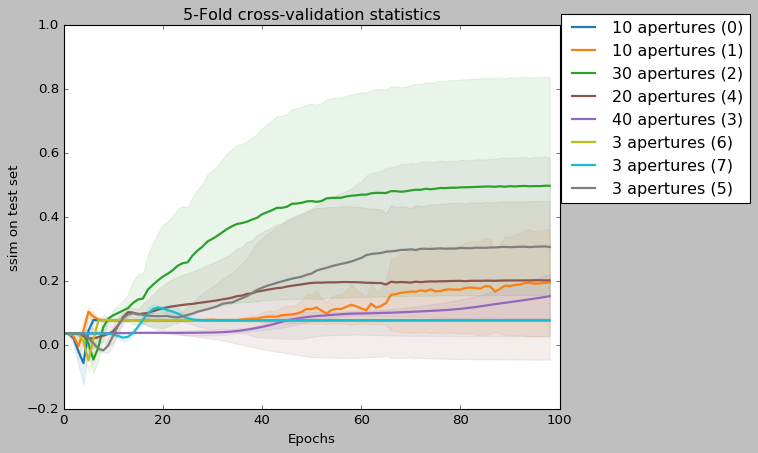

In [219]:

cNorm  = colors.Normalize(vmin=0, vmax=7)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=plt.get_cmap("tab10"))

plt.figure()
plt.style.use("classic")
for h_id, d in mean_results.items():
    holes = hyperparameters[h_id]["mask_holes"]
    plt.plot(list(range(d["mean"].size)), d["mean"], 
             "-", lw=2, color=scalarMap.to_rgba(h_id), label=f"{holes} apertures ({h_id})")
    plt.fill_between(list(range(d["mean"].size)), d["mean"] - d["std"], d["mean"] + d["std"],
                    color=scalarMap.to_rgba(h_id), alpha=0.1)
plt.legend(bbox_to_anchor=(1.4, 1.05))
plt.xlabel("Epochs")
plt.ylabel(metric + " on " + which[:-len("_metric")] + " set")
plt.title("5-Fold cross-validation statistics")
plt.savefig(os.path.join(results_dir, which + "_" + metric + ".png"), bbox_inches="tight")

In [211]:
fold = 4
images = {}
for file in glob.glob(os.path.join(results_dir, "hparams_002", "fold_" + f"{fold:02}", "*.png")):
    name = os.path.split(file)[-1]
    epoch = int(name[7:10])
    index = int(name[11:15])
    step = int(name[16:18])
    with Image.open(file) as image:
        im = np.array(image.getdata()).reshape([image.size[0], image.size[1]])
        update(images, {index: {epoch : {step: im}}})

In [212]:
ground_truth = {}
for file in glob.glob(os.path.join(data_dir, "image[0-9]*")):
    name = os.path.split(file)[-1]
    index = int(name[5:8])
    if index % 100 == 0:
        with Image.open(file) as image:
            im = np.array(image.getdata()).reshape(image.size[0], image.size[1])
            ground_truth[index] = im

In [213]:
%%capture

index = 0 # [0, 500]
step = 2  # [1, 2]
fig = plt.figure()
cam = Camera(fig)
selected_image = images[index]
for key in sorted(list(selected_image.keys())):
    plt.imshow(selected_image[key][step], cmap="gray")
    cam.snap()
animation = cam.animate()
animation.save(os.path.join(results_dir, f"output_haprams_002_fold_{fold:02}.mp4"), writer="ffmpeg")
anim1 = HTML(animation.to_html5_video())

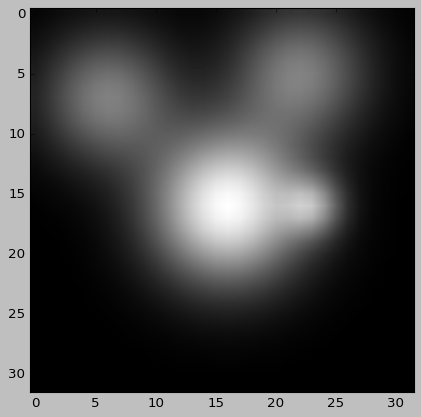

In [214]:
plt.figure()
plt.imshow(ground_truth[index], cmap="gray")
plt.savefig(os.path.join(results_dir, "ground_truth.png"))

In [215]:
anim1

In [202]:
fold = 0
images = {}
for file in glob.glob(os.path.join(results_dir, "hparams_003", "fold_" + f"{fold:02}", "*.png")):
    name = os.path.split(file)[-1]
    epoch = int(name[7:10])
    index = int(name[11:15])
    step = int(name[16:18])
    with Image.open(file) as image:
        im = np.array(image.getdata()).reshape([image.size[0], image.size[1]])
        update(images, {index: {epoch : {step: im}}})

In [205]:
%%capture

index = 0 # [0, 500]
step = 2  # [1, 2]
fig = plt.figure()
cam = Camera(fig)
selected_image = images[index]
for key in sorted(list(selected_image.keys())):
    plt.imshow(selected_image[key][step], cmap="gray")
    cam.snap()
animation = cam.animate()
animation.save(os.path.join(results_dir, f"output_haprams_003_fold_{fold:02}.mp4"), writer="ffmpeg")
anim2 = HTML(animation.to_html5_video())

In [206]:
anim2